# Laplace location


In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import jax.random as random

from validation import run_single_comparison

## Parameters

In [2]:
n = 100
b = 1.0
mu_true = 2.0
T_gibbs = 10000
T_kde = 5000
T_fulldata = 10000
burnin = 1000
seed = 0
cache_dir = "../cache"

prior_mean = 0.0
prior_std = 5.0
kde_bw_method = "scott"
proposal_std_mu = 0.25
base_params = {"prior_mean": prior_mean, "prior_std": prior_std, "kde_bw_method": kde_bw_method,
              "proposal_std_mu": proposal_std_mu}

## Run Gibbs, KDE reference, and full-data MH

In [3]:
key = random.PRNGKey(seed)
out = run_single_comparison(
    "laplace",
    key,
    n,
    mu_true=mu_true,
    T_gibbs=T_gibbs,
    T_kde=T_kde,
    T_fulldata=T_fulldata,
    burnin=burnin,
    verbose=True,
    cache_dir=cache_dir,
    seed_hint=seed,
    base_params=base_params,
    b=b,
)

out["data"]

  Running Gibbs (laplace, T=10000)...


Gibbs (Laplace): 100%|██████████| 10000/10000 [00:31<00:00, 319.72it/s]


  [cache save] Gibbs saved to ../cache/gibbs_model_laplace_1.0_100_prior0p0_5p0_T10000_seed0.npz
  Computing KDE posterior (laplace, 5000 sims)...
Fitting KDE to MLE samples using bw_method = scott
  [cache save] KDE samples saved to ../cache/kde_model_laplace_1.0_100_T5000_seed0.npz
  Running full-data MH (laplace, T=10000)...


Full-data MH (Laplace): 100%|██████████| 10000/10000 [00:10<00:00, 949.42it/s]

  [cache save] Full-data chain saved to ../cache/fulldata_model_laplace_1.0_100_prior0p0_5p0_T10000_seed0.npz


array([ 0.17519282,  3.88320177,  2.63093265,  2.1730453 ,  2.21716895,
        2.51091439,  2.94479359,  3.50932144,  0.11978802,  3.36930398,
        1.20875202,  2.37519746,  1.46298566,  2.38455459,  2.2993907 ,
        1.92091774,  3.01805484,  2.36034775,  4.93012009,  4.19733429,
        3.81043114,  2.11510292,  2.83498724,  2.36882851,  2.74507327,
        5.80235148,  2.3010941 ,  3.78719168,  2.5332792 ,  3.06161992,
        1.81200291,  1.4935061 , -0.16093741,  2.58263975,  1.04487455,
        0.84319467,  3.79224464,  2.08951229,  1.50210313,  1.40760951,
        2.18235504,  2.80192248,  2.99531754,  2.42473786,  1.62186917,
        1.42616736,  1.56157229,  1.15559812,  2.71731229,  1.51362089,
        4.31276508,  3.11738317,  5.59547138,  0.87612233,  2.12929466,
        0.85715397,  1.81263406,  0.01534862,  2.16669543,  1.01093715,
        3.00929234,  2.059782  ,  1.98305759,  2.25674238,  2.16361129,
        2.34647842,  2.8644511 ,  4.62904068,  2.50453748,  2.38

## Summary: means and variances

In [4]:
mle = out["mle"]
print(f"Data: n={n}, true mu={mu_true}, MLE={mle:.4f}")
print()
print("Posterior given MLE (p(mu | MLE)):")
print(f"  Gibbs  mean = {out['gibbs_mean']:.4f}  variance = {out['gibbs_variance']:.6f}")
print(f"  KDE    mean = {out['kde_mean']:.4f}  variance = {out['kde_variance']:.6f}")
print(f"  Variance ratio (Gibbs/KDE): {out['gibbs_variance'] / out['kde_variance']:.4f}")
if out.get('kde_posterior_integral') is not None:
    print(f"  KDE 1D validation (∫ post): {out['kde_posterior_integral']:.6f}  (expect 1.0)")
acc = out.get("gibbs_acceptance", {})
if acc and "mu" in acc:
    print()
    print("Gibbs acceptance rates:")
    print(f"  mu (parameter):   {acc['mu']:.2%}")
print()
print("Posterior given full data (p(mu | x)):")
print(f"  MH     mean = {out['full_data_mean']:.4f}  variance = {out['full_data_variance']:.6f}")
print(f"  Info loss  Var(mu|MLE) / Var(mu|x) = {out['info_loss_ratio']:.4f}")
if "fulldata_mu_acceptance_rate" in out:
    print(f"  MH mu acceptance: {out['fulldata_mu_acceptance_rate']:.2%}")

Data: n=100, true mu=2.0, MLE=2.1777

Posterior given MLE (p(mu | MLE)):
  Gibbs  mean = 2.1735  variance = 0.012368
  KDE    mean = 2.1770  variance = 0.012197
  Variance ratio (Gibbs/KDE): 1.0140
  KDE 1D validation (∫ post): 1.000000  (expect 1.0)

Gibbs acceptance rates:
  mu (parameter):   44.29%

Posterior given full data (p(mu | x)):
  MH     mean = 2.2010  variance = 0.008949
  Info loss  Var(mu|MLE) / Var(mu|x) = 1.3630
  MH mu acceptance: 40.32%


## Overlay: densities of the three posteriors

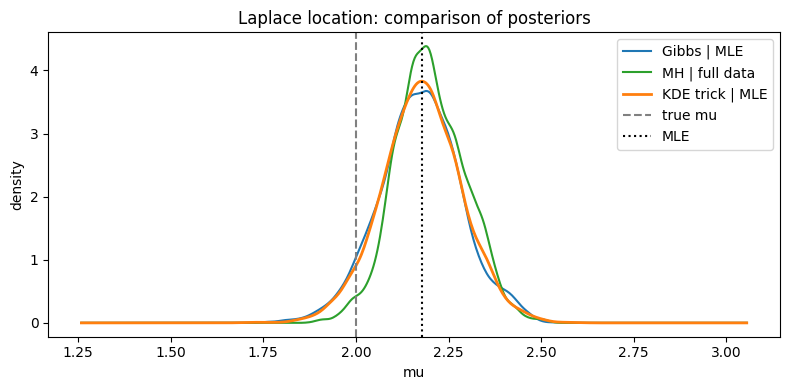

In [6]:
mu_gibbs = out["mu_chain_post_burnin"]
mu_fulldata = out["mu_chain_fulldata"][burnin:]
kde_pdf = out["kde_posterior_pdf"]

lo = min(mu_gibbs.min(), mu_fulldata.min()) - 0.5
hi = max(mu_gibbs.max(), mu_fulldata.max()) + 0.5
mu_grid = np.linspace(lo, hi, 500)
kde_vals = np.maximum(kde_pdf(mu_grid), 1e-20)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
kde_gibbs = gaussian_kde(mu_gibbs, bw_method=kde_bw_method)
kde_fulldata = gaussian_kde(mu_fulldata, bw_method=kde_bw_method)
ax.plot(mu_grid, kde_gibbs(mu_grid), color="C0", label="Gibbs | MLE")
ax.plot(mu_grid, kde_fulldata(mu_grid), color="C2", label="MH | full data")
ax.plot(mu_grid, kde_vals, color="C1", lw=2, label="KDE trick | MLE")
ax.axvline(mu_true, color="gray", ls="--", label="true mu")
ax.axvline(mle, color="black", ls=":", label="MLE")
ax.set_xlabel("mu")
ax.set_ylabel("density")
ax.legend()
ax.set_title("Laplace location: comparison of posteriors")
plt.tight_layout()
plt.show()

## Trace plots (Gibbs and full-data MH)

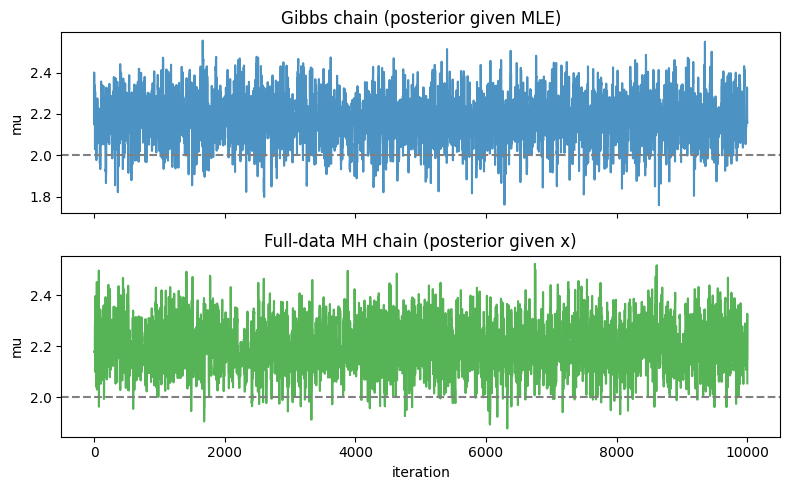

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5), sharex=True)
axes[0].plot(out["mu_chain_gibbs"], alpha=0.8)
axes[0].set_ylabel("mu")
axes[0].set_title("Gibbs chain (posterior given MLE)")
axes[0].axhline(mu_true, color="gray", ls="--")
axes[1].plot(out["mu_chain_fulldata"], alpha=0.8, color="C2")
axes[1].set_ylabel("mu")
axes[1].set_xlabel("iteration")
axes[1].set_title("Full-data MH chain (posterior given x)")
axes[1].axhline(mu_true, color="gray", ls="--")
plt.tight_layout()
plt.show()